In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load
import src.preprocess as preprocess
import src.data_raw as data_raw
from src.util.run_util import create_timedelta_and_plot

from src.util.config import get_config
config = get_config()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

loading config from config/config.yml


# TODO:

- Implement absolute actions, instead of ratios. Implement in tradestrategy. SPecify min/max in config. Similarly, specify max denominator in config (which is incremented with nuimber of actions per type)
- Go back to basic concepts like epochs to understand the Discord discussions perfectly. Kinda link their terminology to the one of stable baselines.
- Double check all available reward functions and classes are fast
    * Dump or rewrite the incremental net worth
- Experiment: Test different setting of exploration
- Experiment: longer training
- Experiment: use minute granularity data
- Experiment: smaller and more updates, i.e. fewer cores.
- Experiment: Use discounted rewards during training to stop training?
- Experiment: add slow TI features
- Experiment: smaller time window for sortino calculation
- Experiment: Discover new promising reward functions (e.g. something more direct on profits?)
- Calculate and show daily and 30 day trading overturn in old fashioned currency
- Download and enable order book data (how do you aggregate orders in time bins?)
- Experiment with orders as features
    * e.g. shape of order book etc.
- Consider ffill nan handling for TI:s (and likely dropping the filled data after)
- Experiments: Test additional models to PPO2. Be careful though, many require different setting in which to run optimally.
- Consider other periods for TI:s, e.g. see https://medium.com/@coinloop/technical-analysis-indicators-and-how-to-use-them-aa0fa706051 and consider having some fixed in time (controlled in config)
- Optimize to save some time every iteration
- Build more advanced slippage handling
- Fetch agent hyperparameters from RL Zoo
- Consider a different training structure, where we train on many smaller rounds, perhaps spread out in time more.
- Hyperparameter search
- Correct for displaced index due to specified TI NaNs (likely uneccessary for all our use cases)
- Get the available LSTM networks working and compare with MLP (tips: https://github.com/hill-a/stable-baselines/issues/646). NOTE: LSTMs also need state during prediction as well as proper env counts for train and test (https://github.com/hill-a/stable-baselines/issues/166 and https://stable-baselines.readthedocs.io/en/master/guide/examples.html#recurrent-policies). Also: https://github.com/hill-a/stable-baselines/issues/308
- Understand more advanced custom policy networks better. See for exampåle  discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759, https://github.com/hill-a/stable-baselines/issues/278, https://github.com/hill-a/stable-baselines/issues/646)
- Check float number type



# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (discrete)
- wrapped running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output
- setup train/test functionality
- Enable saving/loading trained models
- Normalize observations
- Add env checker (disbled by default, but passed)
- lock down the seeds
- Add finer temporal resolution in data (minute granularity)
- Add support for higher frequency data: NaN handling and pushed starting timestamp
- Add technical indicator features
- Add benchmarks
- Add dynamic data download and preparation by downloading all transactions -> render OHLC in multiple time granularities
- Add full support for multiprocessing
- Suppress tensorflow warnings
- Substantial time optimizations to avoid growing time per iteration of training
- Substantial memory savings from only saving data we need during training
- Added flag to refresh data
- No data copy when building Docker cotainer -- MUCH faster Docker builds
- Properly save model, normalization statistics, and some useful meta data
- Save result plots from prediction in model folders
- The reward range is reward specific
- Refactored the trading class: decreased complexity and duplicate calculations
- Proper commission and slippage support (beta distr for slippage)
- Revisited TIs: added TI features and a forward looking check

# Run

In [2]:
record_steptime = False
force_refresh = False

In [3]:
%%time
data_raw.download_and_process(force_refresh=force_refresh)
df = load.load_OHLC_data()
df = preprocess.preprocess_data(df=df, include_slow_features=False)

config.n_cpu=8
env = run.setup_env(df=df, record_steptime=record_steptime)

Processed data available locally, no downloading and raw data processing needed.
LOAD: Loading data with 23615326 samples
PREPROCESS: Dropping 0 NaNs out of 23615326 samples (0.0%) from input file
PREPROCESS: Dropping unused data, 23615326 -> 1760 samples
PREPROCESS: Performing check of forward lookingness of TIs
PREPROCESS: Adding technical features...
Done.
PREPROCESS: Performing NaN/inf check on data...
Done.
Setting up environment using 8 cores...
Resetting to timesteps: start 23613866 (2020-09-28 03:06:11), end 23615075 (2020-09-28 09:31:33)
Done.
CPU times: user 7.26 s, sys: 5.44 s, total: 12.7 s
Wall time: 39.2 s


In [4]:
# EXPERIMENT: with only gentle commission AND new TIs AND 10 data_n_timesteps again

In [5]:
%%time
model = run.train(env=env, n_infoboxes=10)
if record_steptime:
    create_timedelta_and_plot(model=model)

RUN: Training for 1500000 serial timesteps and 12000000 total timesteps...
--------------------------------------
| approxkl           | 0.00010497264 |
| clipfrac           | 0.0           |
| explained_variance | -0.141        |
| fps                | 893           |
| n_updates          | 1             |
| policy_entropy     | 2.1970928     |
| policy_loss        | -0.0026306473 |
| serial_timesteps   | 128           |
| time_elapsed       | 4.08e-05      |
| total_timesteps    | 1024          |
| value_loss         | 1.0742422     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00024385969 |
| clipfrac           | 0.0           |
| explained_variance | -1.38         |
| fps                | 318           |
| n_updates          | 1172          |
| policy_entropy     | 2.0424898     |
| policy_loss        | -0.0029538174 |
| serial_timesteps   | 150016        |
| time_elapsed       | 3.19e+03      |
| total_timesteps    | 12001

RUN: Loading files from ./data/models/15/
Loading a model without an environment, this model cannot be trained until it has a valid environment.
RUN: Model connected with env
RUN: Predicting for 249989 timesteps
Resetting to timesteps: start 23365335 (2020-09-03 15:42:31), end 23615325 (2020-09-28 10:16:00)
Rendering TradingChartStatic for index steps 23365335 (2020-09-03 15:42:31) through 23615324 (2020-09-28 10:15:35)
Not rendering trades since they are too many to distinguish in plot (41450>5000)


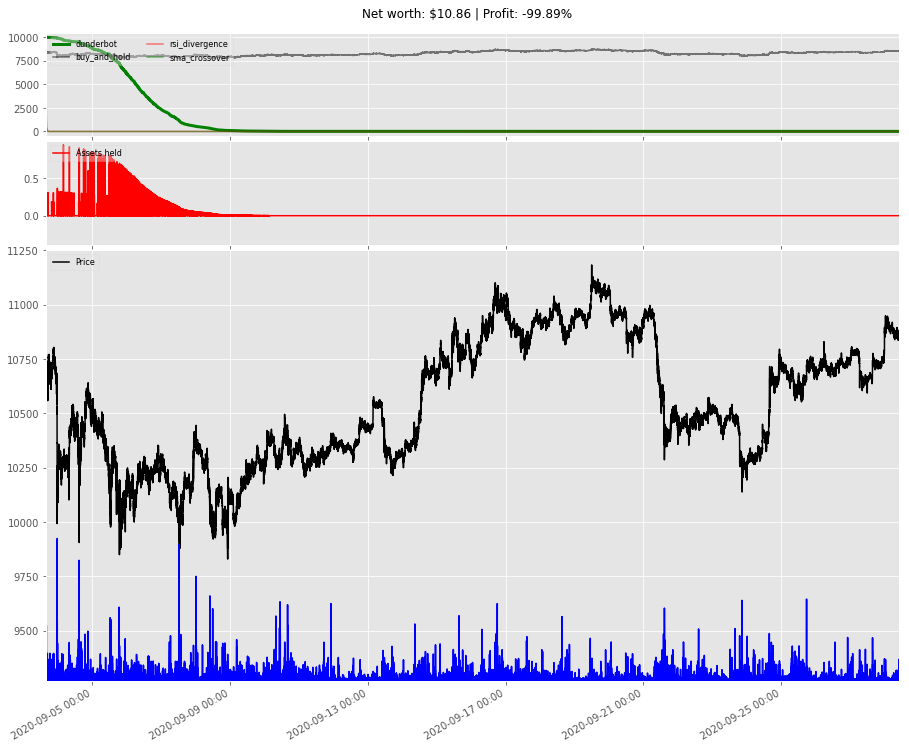

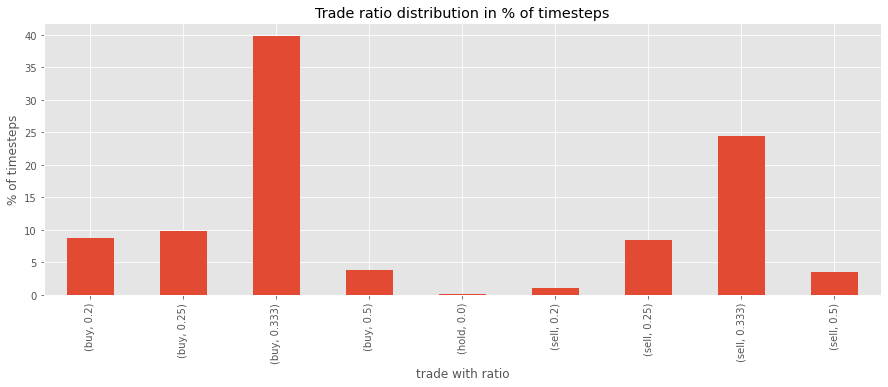

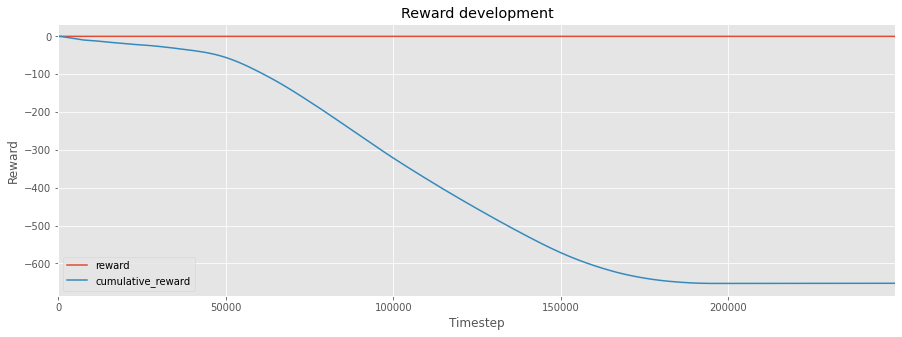

CPU times: user 51min 41s, sys: 0 ns, total: 51min 41s
Wall time: 51min 26s


In [6]:
%%time
run.predict(df=df, rendermode='plots')

In [7]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 23365346,
 'net_worths': [10000,
  9995.01,
  9994.69,
  9995.316,
  9995.405,
  9997.328,
  9995.358,
  9994.763,
  9995.814,
  9994.53,
  9996.954,
  9994.869,
  9995.292,
  10000.79,
  9995.913,
  9995.546,
  9996.759,
  9996.863,
  9996.635,
  9998.643,
  9999.586],
 'trades': [{'step': 23365326,
   'amount': 0.23513827,
   'total': 2500.0,
   'type': 'buy',
   'action_amount': 0.25},
  {'step': 23365327,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365328,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365329,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365330,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365331,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365332,
   'amount': None,
   'total': None,
   'type': 'h

In [7]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'returns', 'account_history', 'rewards'])

In [8]:
x['rewards']

[-0.7071047771842108,
 -0.5171704106450127,
 -0.022499640550915318,
 -0.01861189788346856,
 -0.005321282541311107,
 -0.008125270251776453,
 -0.0082125176536083,
 -0.005810761663444563,
 -0.006947043757195115,
 -0.0030271566103867507,
 -0.004735707613452041,
 -0.00409096231918954,
 0.00046419755618168276,
 -0.002254797343707131,
 -0.002330458757328363,
 -0.001617101279060783,
 -0.001494530262079394,
 -0.001533617328592901,
 -0.0005866921506127211,
 -0.00017095273607833325]

In [9]:
x['returns']

[0,
 -0.0004989999999500781,
 -3.2015975968777716e-05,
 6.263325825388985e-05,
 8.904170712665573e-06,
 0.00019238840245157414,
 -0.0001970526524489636,
 -5.952763272109088e-05,
 0.00010515506969943369,
 -0.0001284537707355496,
 0.00024253266534359652,
 -0.00020856352842981606,
 4.232171526775821e-05,
 0.0005500589677071317,
 -0.00048766147469477363,
 -3.671500541906218e-05,
 0.0001213540510821904,
 1.040337173167387e-05,
 -2.280715460203354e-05,
 0.00020086759192457693,
 9.431279823721966e-05]

In [41]:
returns = np.array(x['returns'][0])
returns = np.array([0])
returns = np.array([1E-6])
#returns = np.array([0,-0.0004989999999500781,])
#returns = np.array([1E-6,-0.0004989999999500781,])

In [42]:
import numpy as np

In [47]:
%timeit if len(returns)>1: pass

80.9 ns ± 0.397 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [43]:
if len(returns)>1
    downside_returns = np.where(returns < 0, returns**2, returns)

    expected_return = np.mean(returns)
    downside_std = np.sqrt(np.std(downside_returns))

    print((expected_return) / (downside_std + 1E-9))
else:
    print(0/1)

0.0


In [34]:
print(returns)
print(downside_returns)
print(downside_std)

[ 0.       -0.000499]
[0.00000e+00 2.49001e-07]
0.0003528462837767871


# TA

In [3]:
import ta

In [2]:
data_raw.download_and_process(force_refresh=False)
df = load.load_OHLC_data()
df = preprocess.drop_nans_from_data(df=df)
df = preprocess.trim_df(df=df)

Processed data avilable locally, no downloading and raw data processing needed.
LOAD: Loading data with 23615326 samples
PREPROCESS: Dropping 0 NaNs out of 23615326 samples (0.0%) from input file
PREPROCESS: Dropping unused data, 23615326 -> 1750001 samples


In [5]:
%%time
BB = ta.volatility.BollingerBands(close=df['Close'], n=20, ndev=2, fillna=False)
df['ti_bb_hind'] = BB.bollinger_hband_indicator()
df['ti_bb_lind'] = BB.bollinger_lband_indicator()
# NOTE: too many inf/nan on 1s-data
df['ti_bb_pband'] = BB.bollinger_pband()
df['ti_bb_wband'] = BB.bollinger_wband()

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 130 ms


In [6]:
%%time
# Ichimoku
II = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], n1=9, n2=26, n3=52, visual=False, fillna=False)
df['ti_ii_senkou_a'] = II.ichimoku_a()
df['ti_ii_senkou_b'] = II.ichimoku_b()
df['ti_ii_kijun_sen'] = II.ichimoku_base_line()

CPU times: user 323 ms, sys: 0 ns, total: 323 ms
Wall time: 322 ms


In [7]:
%%time
# Relative Strength Index (RSI)
# TODO: consider adding binary features for above 70 and below 30 (i.e. standard interpretation)
RSI = ta.momentum.RSIIndicator(close=df['Close'], n=14, fillna=False)
df['ti_rsi'] = RSI.rsi()

CPU times: user 274 ms, sys: 0 ns, total: 274 ms
Wall time: 273 ms


In [8]:
%%time
# Moving Average Convergence Divergence (MACD)
MACD = ta.trend.MACD(close=df['Close'], n_slow=26, n_fast=12, n_sign=9, fillna=False)
df['ti_macd_hist'] = MACD.macd_diff()

CPU times: user 344 ms, sys: 0 ns, total: 344 ms
Wall time: 342 ms


In [9]:
%%time
# Average Directional Movement Index (ADX)
ADX = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], n=14, fillna=False)    
df['ti_adx'] = ADX.adx()
df['ti_adx_neg'] = ADX.adx_neg()
df['ti_adx_pos'] = ADX.adx_pos()

CPU times: user 1min 53s, sys: 0 ns, total: 1min 53s
Wall time: 1min 53s


In [10]:
%%time
# Commodity Channel Index (CCI)
# NOTE: too many infs on 1s data
CCI = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], n=20, c=0.015, fillna=False)
df['ti_cci'] = CCI.cci()

CPU times: user 34.8 s, sys: 0 ns, total: 34.8 s
Wall time: 34.8 s


In [11]:
%%time
# Chaikin Money Flow (CMF)
CMF = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['VolumeBTC'], n=20, fillna=False)
df['ti_cmf'] = CMF.chaikin_money_flow()

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 102 ms


In [12]:
%%time
# Parabolic Stop and Reverse (Parabolic SAR)
# NOTE: removed because too slow
PSAR = ta.trend.PSARIndicator(high=df['High'], low=df['Low'], close=df['Close'], step=0.02, max_step=0.2, fillna=False)
df['ti_psar_dind'] = PSAR.psar_down_indicator()
df['ti_psar_uind'] = PSAR.psar_up_indicator()

CPU times: user 45min 55s, sys: 11min 57s, total: 57min 52s
Wall time: 57min 50s


In [6]:
import ta

In [9]:
%%time
# StochasticOscillator (SO)
SO = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], n=14, d_n=3, fillna=False)
df['ti_so'] = SO.stoch()
df['ti_so_signal'] = SO.stoch_signal()

CPU times: user 186 ms, sys: 935 µs, total: 187 ms
Wall time: 186 ms


In [10]:
df[[]]

,Timestamp,Open,High,Low,Close,VolumeBTC,Symbol,ti_bb_hind,ti_bb_lind,ti_bb_wband,...,ti_ii_senkou_b,ti_ii_kijun_sen,ti_rsi,ti_macd_hist,ti_adx,ti_adx_neg,ti_adx_pos,ti_cmf,ti_so,ti_so_signal
21865325,2020-04-03 06:59:20,6803.79,6803.79,6803.79,6803.79,0.098682,BTCUSD,0.0,0.0,NaN,...,6803.790,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
21865326,2020-04-03 06:59:28,6808.45,6808.45,6808.45,6808.45,0.170640,BTCUSD,0.0,0.0,NaN,...,6806.120,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
21865327,2020-04-03 06:59:39,6803.91,6803.91,6803.91,6803.91,0.014525,BTCUSD,0.0,0.0,NaN,...,6806.120,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
21865328,2020-04-03 07:00:05,6803.79,6803.79,6801.92,6801.92,0.133000,BTCUSD,0.0,0.0,NaN,...,6805.185,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
21865329,2020-04-03 07:00:09,6807.32,6807.33,6807.32,6807.33,0.252463,BTCUSD,0.0,0.0,NaN,...,6805.185,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23615321,2020-09-28 10:14:57,10876.16,10876.16,10875.12,10875.12,0.010088,BTCUSD,0.0,0.0,0.068137,...,10877.550,10879.04,46.793894,-0.322891,32.520021,36.214151,46.840605,0.565185,1.485149,10.066007
23615322,2020-09-28 10:15:17,10881.87,10881.88,10881.87,10881.88,0.217167,BTCUSD,1.0,0.0,0.077721,...,10877.550,10879.04,60.635998,0.058975,32.749644,26.817792,56.641895,0.577860,85.148515,33.663366
23615323,2020-09-28 10:15:27,10877.50,10877.50,10877.50,10877.50,0.021824,BTCUSD,0.0,0.0,0.075898,...,10877.550,10879.04,51.319818,0.010194,31.237827,38.001206,47.959017,0.579076,30.940594,39.191419
23615324,2020-09-28 10:15:35,10877.49,10877.49,10877.49,10877.49,0.003000,BTCUSD,0.0,0.0,0.073777,...,10877.760,10879.04,51.300439,-0.027090,29.830504,38.024565,47.940948,0.580631,30.816832,48.968647


In [15]:
df.head()

,Timestamp,Open,High,Low,Close,VolumeBTC,Symbol,ti_bb_hind,ti_bb_lind,ti_bb_wband,...,ti_ii_senkou_b,ti_ii_kijun_sen,ti_rsi,ti_macd_hist,ti_adx,ti_adx_neg,ti_adx_pos,ti_cmf,ti_so,ti_so_signal
21865325,2020-04-03 06:59:20,6803.79,6803.79,6803.79,6803.79,0.098682,BTCUSD,0.0,0.0,NaN,...,6803.790,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
21865326,2020-04-03 06:59:28,6808.45,6808.45,6808.45,6808.45,0.170640,BTCUSD,0.0,0.0,NaN,...,6806.120,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
21865327,2020-04-03 06:59:39,6803.91,6803.91,6803.91,6803.91,0.014525,BTCUSD,0.0,0.0,NaN,...,6806.120,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
21865328,2020-04-03 07:00:05,6803.79,6803.79,6801.92,6801.92,0.133000,BTCUSD,0.0,0.0,NaN,...,6805.185,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
21865329,2020-04-03 07:00:09,6807.32,6807.33,6807.32,6807.33,0.252463,BTCUSD,0.0,0.0,NaN,...,6805.185,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


In [25]:
df['ewm8'] = df['Close'].ewm(span=20, min_periods=20, adjust=False).mean()

<AxesSubplot:>

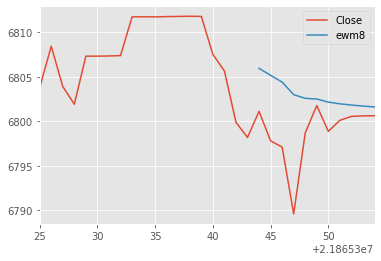

In [27]:
df[['Close', 'ewm8']].head(30).plot()

In [28]:
%%time
# EMA8
span = 8
df['ti_EMA8'] = df['Close'].ewm(span=span, min_periods=span, adjust=False).mean()

# EMA50
span = 50
df['ti_EMA50'] = df['Close'].ewm(span=span, min_periods=span, adjust=False).mean()

# EMA100
span = 100
df['ti_EMA100'] = df['Close'].ewm(span=span, min_periods=span, adjust=False).mean()

# EMA200
span = 200
df['ti_EMA200'] = df['Close'].ewm(span=span, min_periods=span, adjust=False).mean()

CPU times: user 456 ms, sys: 2.77 ms, total: 459 ms
Wall time: 458 ms


In [29]:
%%time
# AwesomeOscillator
AO = ta.momentum.AwesomeOscillatorIndicator(high=df['High'], low=df['Low'], s=5, len=34, fillna=False)
df['ti_ao'] = AO.ao()

CPU times: user 98.3 ms, sys: 12.4 ms, total: 111 ms
Wall time: 107 ms


In [30]:
df.replace([np.inf, -np.inf], np.nan).isna().sum()

Timestamp             0
Open                  0
High                  0
Low                   0
Close                 0
VolumeBTC             0
Symbol                0
ti_bb_hind            0
ti_bb_lind            0
ti_bb_wband          19
ti_ii_senkou_a       25
ti_ii_senkou_b        0
ti_ii_kijun_sen      25
ti_rsi               13
ti_macd_hist         33
ti_adx                0
ti_adx_neg            0
ti_adx_pos            0
ti_cmf               19
ti_so              1428
ti_so_signal       1994
ewm8                 19
ti_EMA8               7
ti_EMA50             49
ti_EMA100            99
ti_EMA200           199
ti_ao                33
dtype: int64

In [31]:
df.isna().sum()

Timestamp             0
Open                  0
High                  0
Low                   0
Close                 0
VolumeBTC             0
Symbol                0
ti_bb_hind            0
ti_bb_lind            0
ti_bb_wband          19
ti_ii_senkou_a       25
ti_ii_senkou_b        0
ti_ii_kijun_sen      25
ti_rsi               13
ti_macd_hist         33
ti_adx                0
ti_adx_neg            0
ti_adx_pos            0
ti_cmf               19
ti_so              1428
ti_so_signal       1994
ewm8                 19
ti_EMA8               7
ti_EMA50             49
ti_EMA100            99
ti_EMA200           199
ti_ao                33
dtype: int64

In [32]:
df.loc[df['ti_so_signal'].isna()]

,Timestamp,Open,High,Low,Close,VolumeBTC,Symbol,ti_bb_hind,ti_bb_lind,ti_bb_wband,...,ti_adx_pos,ti_cmf,ti_so,ti_so_signal,ewm8,ti_EMA8,ti_EMA50,ti_EMA100,ti_EMA200,ti_ao
21865325,2020-04-03 06:59:20,6803.79,6803.79,6803.79,6803.79,0.098682,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21865326,2020-04-03 06:59:28,6808.45,6808.45,6808.45,6808.45,0.170640,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21865327,2020-04-03 06:59:39,6803.91,6803.91,6803.91,6803.91,0.014525,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21865328,2020-04-03 07:00:05,6803.79,6803.79,6801.92,6801.92,0.133000,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21865329,2020-04-03 07:00:09,6807.32,6807.33,6807.32,6807.33,0.252463,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23608311,2020-09-27 01:08:42,10800.00,10800.00,10800.00,10800.00,0.733162,BTCUSD,0.0,0.0,0.022682,...,63.551099,0.065228,NaN,NaN,10799.419686,10800.008975,10794.981390,10787.068464,10775.072393,1.386176
23608312,2020-09-27 01:08:57,10800.00,10800.00,10800.00,10800.00,0.283560,BTCUSD,0.0,0.0,0.022682,...,63.551099,0.062493,NaN,NaN,10799.474954,10800.006981,10795.178198,10787.324534,10775.320429,1.014412
23608313,2020-09-27 01:08:58,10800.00,10800.00,10800.00,10800.00,0.067751,BTCUSD,0.0,0.0,0.022682,...,63.551099,0.065745,NaN,NaN,10799.524959,10800.005429,10795.367289,10787.575533,10775.565997,0.644706
23608314,2020-09-27 01:09:02,10803.12,10803.84,10803.12,10803.84,2.374808,BTCUSD,1.0,0.0,0.037432,...,79.506826,0.360366,100.0,NaN,10799.935915,10800.857556,10795.699552,10787.897602,10775.847331,0.868353


In [44]:
import pandas as pd
import ta

test_len = 5000
df_small = df.iloc[:test_len*2].copy()
df_smaller = df.iloc[:test_len].copy()

df_small = preprocess.add_technical_features(df=df_small, include_slow_features=False)
df_smaller = preprocess.add_technical_features(df=df_smaller, include_slow_features=False)

ti_cols = [col for col in df_small.columns if 'ti_' in col]
for ti_col in ti_cols:
    assert df_smaller[ti_col].equals(df_small[ti_col].iloc[:test_len]), f'TI {ti_col} potentially forward looking'

PREPROCESS: Adding technical features...
Done.
PREPROCESS: Adding technical features...
Done.


AssertionError: TI ti_ii_senkou_a potentially forward looking

In [35]:
ti_col

'ti_bb_hind'

In [41]:
df_smaller[ti_col].equals(df_small[ti_col].iloc[:test_len])

True

In [39]:
df_smaller['ti_bb_hind']

21865325    0.0
21865326    0.0
21865327    0.0
21865328    0.0
21865329    0.0
           ... 
21870320    0.0
21870321    0.0
21870322    0.0
21870323    0.0
21870324    0.0
Name: ti_bb_hind, Length: 5000, dtype: float64

In [40]:
df_small.iloc[:test_len]

,Timestamp,Open,High,Low,Close,VolumeBTC,Symbol,ti_bb_hind,ti_bb_lind,ti_bb_wband,...,ti_adx_pos,ti_cmf,ti_so,ti_so_signal,ewm8,ti_EMA8,ti_EMA50,ti_EMA100,ti_EMA200,ti_ao
21865325,2020-04-03 06:59:20,6803.79,6803.79,6803.79,6803.79,0.098682,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21865326,2020-04-03 06:59:28,6808.45,6808.45,6808.45,6808.45,0.170640,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21865327,2020-04-03 06:59:39,6803.91,6803.91,6803.91,6803.91,0.014525,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21865328,2020-04-03 07:00:05,6803.79,6803.79,6801.92,6801.92,0.133000,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21865329,2020-04-03 07:00:09,6807.32,6807.33,6807.32,6807.33,0.252463,BTCUSD,0.0,0.0,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21870320,2020-04-03 16:13:00,6656.76,6656.76,6656.76,6656.76,0.004235,BTCUSD,0.0,0.0,0.239738,...,44.277880,-0.375106,23.430657,23.406326,6658.934509,6657.585761,6657.977457,6659.735288,6670.032912,-4.727382
21870321,2020-04-03 16:13:04,6656.76,6656.76,6656.76,6656.76,0.157876,BTCUSD,0.0,0.0,0.239857,...,44.277880,-0.430818,25.235849,24.032388,6658.727413,6657.402258,6657.929714,6659.676372,6669.900843,-4.153324
21870322,2020-04-03 16:13:05,6653.81,6653.81,6653.08,6653.08,2.290000,BTCUSD,0.0,0.0,0.241610,...,40.493263,-0.653875,0.000000,16.222169,6658.189564,6656.441757,6657.739529,6659.545751,6669.733472,-4.069118
21870323,2020-04-03 16:13:09,6656.11,6656.11,6656.11,6656.11,0.647030,BTCUSD,0.0,0.0,0.244576,...,42.988237,-0.611200,22.971948,16.069266,6657.991510,6656.368033,6657.675626,6659.477716,6669.597915,-4.145647


In [5]:
verbose=True
if verbose: print('test')

test


In [ ]:
from src.